<a href="https://colab.research.google.com/github/ClaudeKanah/KD/blob/main/trasferimento_stili.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Ti diamo il benvenuto in Colab</h1>
</div>

<!-- TODO(b/319266067) remove temporary advert after a few weeks. -->
<div class="markdown-google-sans">
  <h2>&#40;Novità&#41; Prova l'API Gemini</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


Se conosci già Colab, guarda questo video per avere informazioni sulle tabelle interattive, sulla visualizzazione della cronologia del codice eseguito e sulla tavolozza dei comandi.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  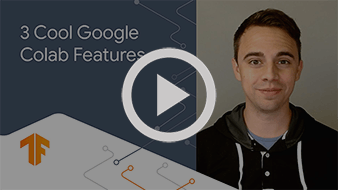
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Cos'è Colab?</h2>
</div>

Colab, o "Colaboratory", ti permette di scrivere ed eseguire Python nel tuo browser con
- Nessuna configurazione necessaria
- Accesso alle GPU senza costi
- Condivisione semplificata

Che tu sia <strong>studente</strong>, <strong>data scientist</strong> o <strong>ricercatore AI</strong>, Colab può semplificarti il lavoro. Guarda <a href="https://www.youtube.com/watch?v=inN8seMm7UI">questo video introduttivo su Colab</a> per ulteriori informazioni oppure inizia qui sotto.

<div class="markdown-google-sans">

## <strong>Introduzione</strong>
</div>

Il documento che stai leggendo non è una pagina web statica, ma un ambiente interattivo chiamato <strong>blocco note Colab</strong> che ti permette di scrivere ed eseguire codice.

Ad esempio, qui vediamo una <strong>cella di codice</strong> con un breve script Python che calcola un valore, lo archivia in una variabile e stampa i risultati:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TF Version:  2.15.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  []


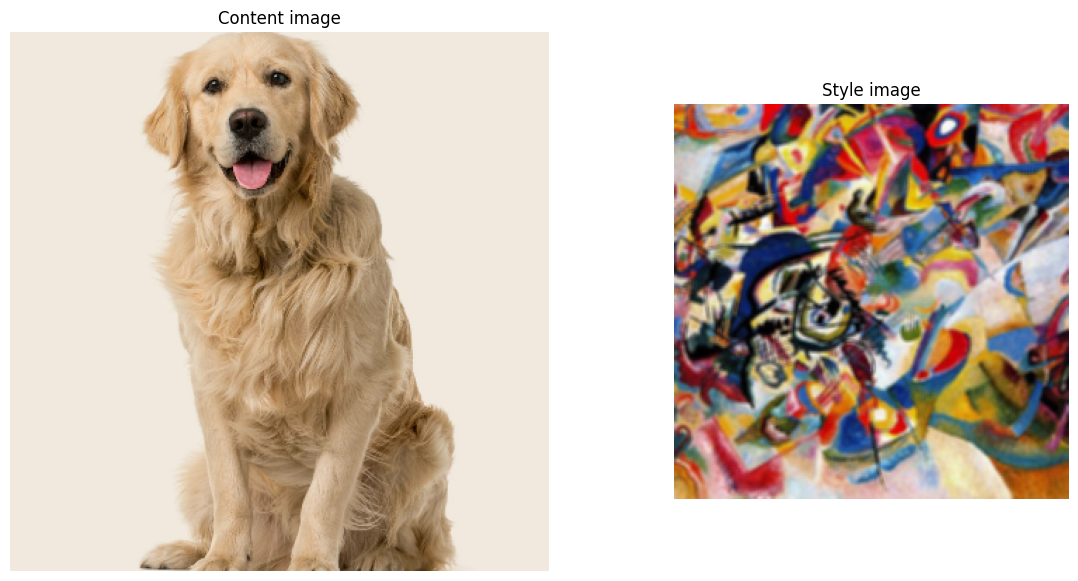

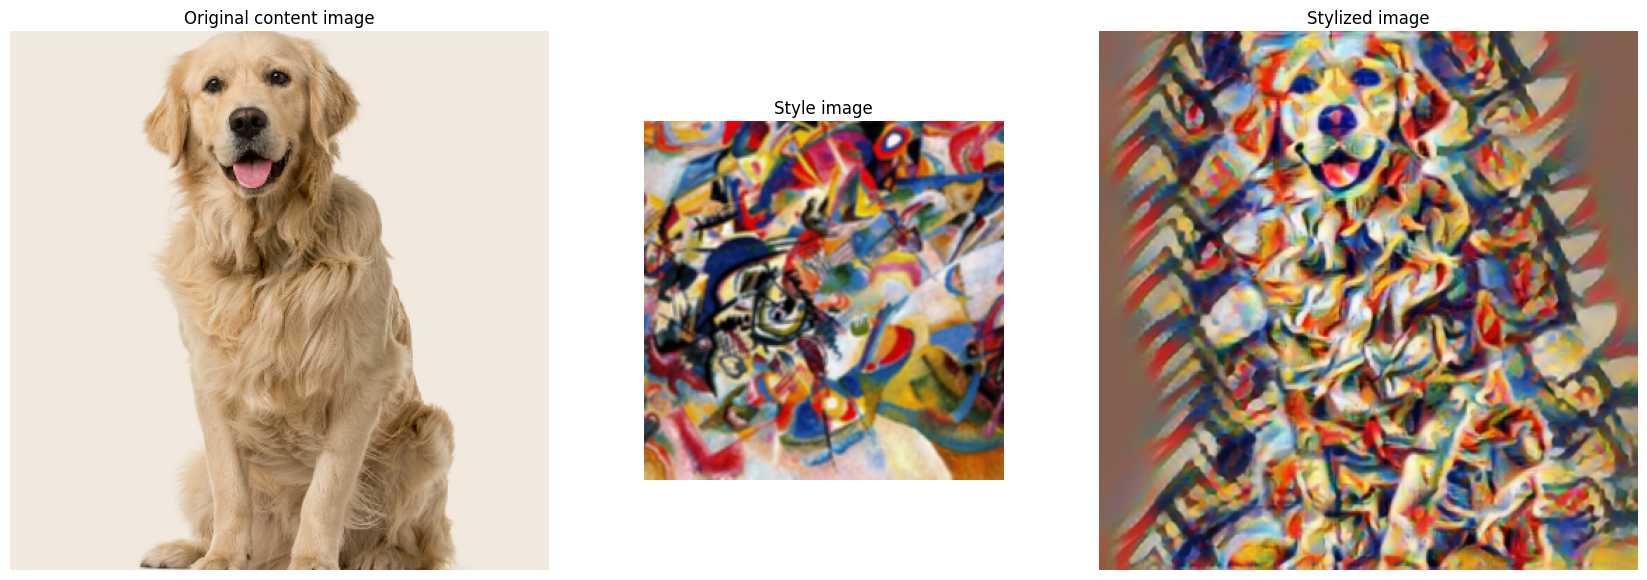

In [16]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')


import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

# @title Load example images  { display-mode: "form" }

#content_image_url ='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/600px-Cat03.jpg'  # @param {type:"string"}
content_image_url ='https://a.storyblok.com/f/152976/1500x1696/093f24b134/golden-retriever.jpg'

#style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
style_image_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'


output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

folder_path = '/content/drive/My Drive/claude/'
file_name = 'stylized_image.jpg'
output_path = folder_path + file_name

# Assicurati che la cartella 'claude' esista
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.imsave(output_path, stylized_image.numpy()[0])



Per eseguire il codice nella cella sopra, selezionala con un clic e poi premi il pulsante Riproduci a sinistra del codice o usa la scorciatoia da tastiera "Comando/Ctrl+Invio". Per modificare il codice, fai clic sulla cella e inizia a modificare.

Le variabili che definisci in una cella possono essere usate in seguito in altre celle:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

I blocchi note Colab ti permettono di combinare <strong>codice eseguibile</strong> e <strong>RTF</strong> in un unico documento, insieme a <strong>immagini</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> e altro ancora. Quando crei dei blocchi note Colab, questi vengono archiviati nel tuo account Google Drive. Puoi condividere facilmente i blocchi note Colab con collaboratori o amici e dare loro la possibilità di commentare o modificare. Leggi ulteriori informazioni in <a href="/notebooks/basic_features_overview.ipynb">Panoramica di Colab</a>. Per creare un nuovo blocco note Colab, puoi usare il menu File qui sopra o questo link: <a href="http://colab.research.google.com#create=true">crea un nuovo blocco note Colab</a>.

I blocchi note Colab sono blocchi note Jupyter ospitati da Colab. Per ulteriori informazioni sul progetto Jupyter, visita <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Data science
</div>

Con Colab puoi sfruttare tutta la potenza delle librerie Python per analizzare e visualizzare i dati. La seguente cella di codice usa <strong>numpy</strong> per generare alcuni dati casuali e usa <strong>matplotlib</strong> per visualizzarli. Per modificare il codice, fai clic sulla cella e inizia a modificare.

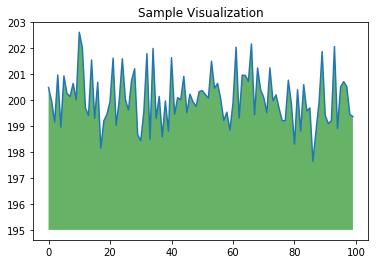

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

Puoi importare i tuoi dati nei blocchi note Colab dal tuo account Google Drive, inclusi i fogli di lavoro, da GitHub e molte altre fonti. Per ulteriori informazioni sull'importazione dei dati e sulle possibilità di utilizzo di Colab per la data science, vedi i link di seguito, sotto <a href="#working-with-data">Utilizzo dei dati</a>.

<div class="markdown-google-sans">

## Machine learning
</div>

Con Colab puoi importare un set di dati immagine, addestrare un classificatore di immagini e valutare il modello, il tutto in <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">poche righe di codice</a>. I blocchi note Colab eseguono il codice sui server cloud di Google, il che significa che puoi utilizzare la potenza dell'hardware Google, tra cui <a href="#using-accelerated-hardware">GPU e TPU</a>, a prescindere dalla potenza della tua macchina. Ti serve solo un browser.

Colab è ampiamente utilizzato dalla community del machine learning con applicazioni che includono:
- Introduzione a TensorFlow
- Sviluppo e addestramento di reti neurali
- Esperimenti con TPU
- Diffusione della ricerca sull'AI
- Creazione di tutorial

Per vedere degli esempi di blocchi note Colab che dimostrano le applicazioni di machine learning, vedi i seguenti <a href="#machine-learning-examples">esempi di machine learning</a>.

<div class="markdown-google-sans">

## Altre risorse

### Utilizzo dei blocchi note in Colab

</div>

- [Panoramica di Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guida a Markdown](/notebooks/markdown_guide.ipynb)
- [Importazione di librerie e installazione di dipendenze](/notebooks/snippets/importing_libraries.ipynb)
- [Salvataggio e caricamento dei blocchi note in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Moduli interattivi](/notebooks/forms.ipynb)
- [Widget interattivi](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Utilizzo dei dati
</div>

- [Caricamento dei dati: Drive, Fogli e Google Cloud Storage](/notebooks/io.ipynb)
- [Grafici: visualizzare i dati](/notebooks/charts.ipynb)
- [Introduzione a BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

Ecco alcuni dei blocchi note dal corso online sul machine learning di Google. Vedi il <a href="https://developers.google.com/machine-learning/crash-course/">sito web del corso completo</a> per ulteriori informazioni.
- [Introduzione al DataFrame Pandas](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Regressione lineare con tf.keras usando dati sintetici](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Utilizzo di hardware accelerato
</div>

- [TensorFlow con GPU](/notebooks/gpu.ipynb)
- [TensorFlow con TPU](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Esempi in primo piano

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">Scambio di voce NeMo</a>. Usa il toolkit di AI di conversazione NeMo di Nvidia per scambiare una voce in un frammento audio con una voce generata automaticamente.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Riaddestramento di un classificatore di immagini</a>: crea un modello Keras utilizzando un classificatore di immagini preaddestrato per distinguere i fiori.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Classificazione del testo</a>: classifica le recensioni dei film IMDB come <em>positive</em> o <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Trasferimento dello stile</a>: usa il deep learning per trasferire lo stile da un'immagine all'altra.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: usa un modello di machine learning per rispondere alle domande del set di dati SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Interpolazione video</a>: prevedi gli eventi di un video tra il primo e l'ultimo frame.
